# Importing Libraries

In [1]:
#importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import random
from torch import flatten #flattening before fc layer
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST  #importing MNIST dataset
from tqdm import tqdm
from torchvision import transforms #for transforming the training and testing data 
from torch.utils.data import DataLoader #Dataloader loads the data batchwise with shuffling in a hassle free manner
from torch.optim import Adam #Adam for GD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler #performs normalization
from sklearn.metrics import mean_squared_error as mse #for MSE 
from PIL import Image as im #used to convert the given image array to a b/w image
from skimage import img_as_ubyte #preserving 0-255 range for skimage.transform.resize
import skimage.transform #to resize the image
from torchvision.utils import make_grid #to visualize the kernels the tensors

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks for gpu else runs in cpu

In [3]:
transform = transforms.ToTensor()
trainset = MNIST('', download=True, train=True, transform=transform)
testset = MNIST('',download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=500)
testloader = torch.utils.data.DataLoader(testset,batch_size=500)

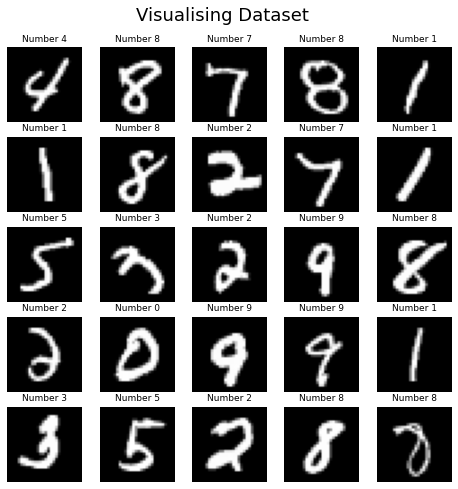

In [4]:
# Plotting 25 random data points from the dataset to get an idea of the dataset
figure = plt.figure(figsize=(8, 8))
figure.suptitle("Visualising Dataset", fontsize=18, y=0.95)

cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title('Number {}'.format(label), fontsize=9)
    plt.axis("off")
    plt.imshow(torch.reshape(img, (28,28)), cmap="gray")
plt.show()

In [5]:
imageset=np.zeros((10,28,28))
imageset=torch.from_numpy(imageset)
imageset=imageset.float()
complabel=0
while(complabel<10):
  for images,labels in testloader:
    for i in range(labels.size(0)):
      if(labels[i]==complabel):
        imageset[complabel]=images[i].clone()
        complabel+=1

# 1. Compare PCA and AutoEncoder

#### PCA Reconstruction

In [6]:
def Visualize_Reconstr_PCA(reconstructed_data):
    
    data_ind  = [6003,416,6754,1605,5055,7965,517,5551,7070,6420] #indices of various digits from the test set
    #fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(5, 5))
    for i,ind in enumerate(data_ind):
        #visualizing the image just for clarity
        image_sample = np.asarray(255*reconstructed_data[ind],dtype = np.uint8).reshape(28,28)
        #ax[0,0].imshow(image_sample,'gray')
        plt.imshow(image_sample,'gray')
        plt.show()

In [7]:
pcatrain=(trainset.data).reshape(60000,784)
pcatest=testset.data.reshape(10000,784)
train_data = np.asarray(pcatrain)/255
test_data = np.asarray(pcatest)/255

In [8]:
PCA_data = np.concatenate((train_data,test_data))
pca1 = PCA(n_components = 30) #as we take first 30 eigenvalues
pca1.fit(PCA_data)
train_pca = pca1.transform(PCA_data)
reconstructed_data = pca1.inverse_transform(train_pca)
PCA_error = mse(PCA_data,reconstructed_data)
print('Reconstruction error made by PCA: ',PCA_error)
#Visualize_Reconstr_PCA(reconstructed_data)
#plt.imshow(reconstructed_data[5].reshape(28,28),cmap='gray')

Reconstruction error made by PCA:  0.01805634114106701


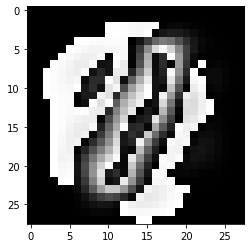

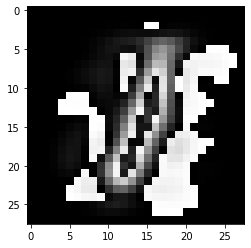

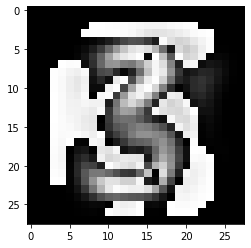

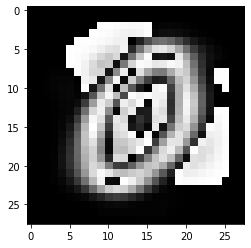

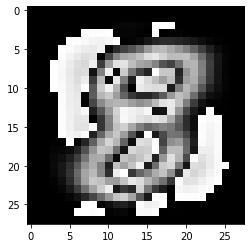

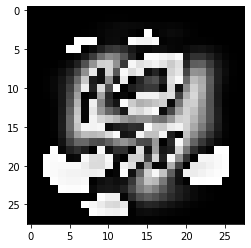

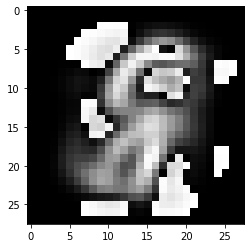

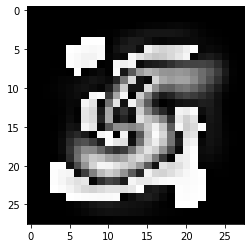

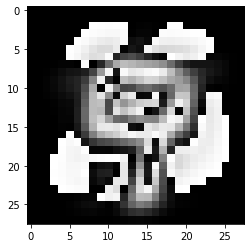

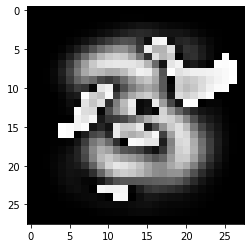

In [9]:
Visualize_Reconstr_PCA(reconstructed_data)


#### AE Reconstruction

In [33]:
class AE_Compare(nn.Module):
  def __init__(self):
    super(AE_Compare, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x    

In [34]:
LearningRate=0.0003
epochs=10
model_Q1 = AE_Compare()
print(model_Q1)

AE_Compare(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=30, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): ReLU()
  )
)


In [35]:
criterionQ1 = nn.MSELoss()
optimizerQ1 = torch.optim.Adam(model_Q1.parameters(), lr=LearningRate)
validationaccuracy_listQ1 = []
validationloss_listQ1 = []
trainingloss_listQ1 = []
test_loss = 0
test_length = len(testloader)


for epoch in range(epochs):
  print('Epoch:', epoch + 1)
  for images, labels in tqdm(trainloader):
    images=images.reshape(500,784)
    outputs = model_Q1(images.float())
    _,predicted=torch.max(outputs.data, 1)
    loss = criterionQ1(outputs, images)
    trainingloss_listQ1.append(loss.item())
    optimizerQ1.zero_grad()
    loss.backward()
    optimizerQ1.step()
    #trainingloss_listQ1.append(loss.item())         
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs = model_Q1(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterionQ1(outputs, images)
        test_loss    += loss/test_length
  validationloss_listQ1.append(loss.item())
      

Epoch: 1


100%|██████████| 20/20 [00:01<00:00, 14.56it/s]


Epoch: 2


100%|██████████| 20/20 [00:01<00:00, 14.75it/s]


Epoch: 3


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  5.79it/s]


Epoch: 5


100%|██████████| 20/20 [00:01<00:00, 14.62it/s]


Epoch: 6


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


Epoch: 7


100%|██████████| 20/20 [00:01<00:00, 14.45it/s]


Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 14.28it/s]


Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 14.63it/s]


Epoch: 10


100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


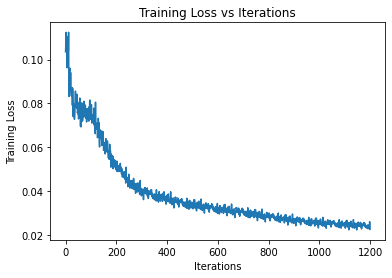

In [48]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_listQ1))
plt.plot(xtrainloss,trainingloss_listQ1)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

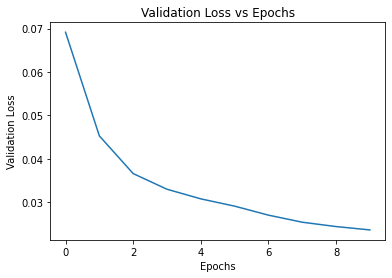

In [36]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_listQ1))
plt.plot(xtestloss,validationloss_listQ1)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [101]:
# Reconstruction Accuracy on Train and Test Data
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp = model_Q1(X)
        train_loss_new += criterionQ1(temp,X)
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp = model_Q1(X)
        test_loss_new += criterionQ1(temp, X)
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 4.8274385335389525e-05
Reconstruction Error on Test Data = 4.787549187312834e-05




 For Image :  0


<Figure size 432x288 with 0 Axes>

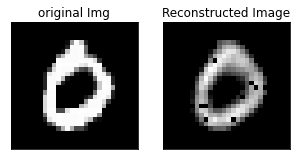



 For Image :  1


<Figure size 432x288 with 0 Axes>

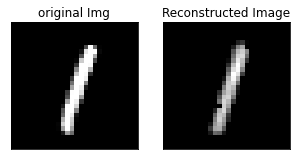



 For Image :  2


<Figure size 432x288 with 0 Axes>

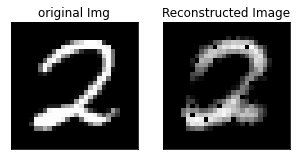



 For Image :  3


<Figure size 432x288 with 0 Axes>

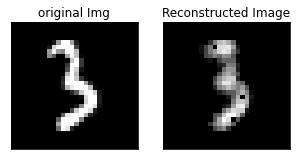



 For Image :  4


<Figure size 432x288 with 0 Axes>

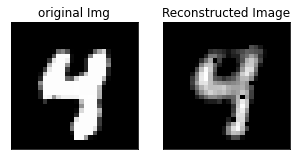



 For Image :  5


<Figure size 432x288 with 0 Axes>

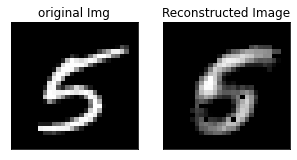



 For Image :  6


<Figure size 432x288 with 0 Axes>

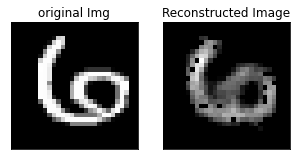



 For Image :  7


<Figure size 432x288 with 0 Axes>

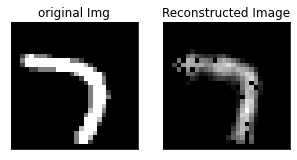



 For Image :  8


<Figure size 432x288 with 0 Axes>

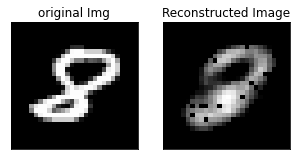



 For Image :  9


<Figure size 432x288 with 0 Axes>

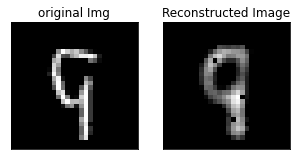

In [38]:
for i in range(10):

    print()
    print("\n For Image : ", i)
    output_ae=model_Q1(imageset[i].reshape(1,784).float())
    plt.figure(1)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (5, 5))
    ax1.set_xticks([])
    ax1.set_yticks([])
    im=ax1.imshow(imageset[i],cmap='gray')

    ax2.set_xticks([])
    ax2.set_yticks([])
    im=ax2.imshow(output_ae.detach().numpy()[0].reshape(28,28),cmap='gray')
    ax2.set_xticks([])
    ax2.set_yticks([])
    im=ax2.imshow(output_ae.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax1.title.set_text('original Img')
    ax2.title.set_text('Reconstructed Image')

    plt.show()
   

    i+=1


# 2. Experimenting with hidden units of various size 

In [39]:
class AE_hid(nn.Module):
  def __init__(self,hidsize):
    super(AE_hid, self).__init__()
    self.hidsize=hidsize
    self.encoder = nn.Sequential(
        nn.Linear(784,hidsize),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(hidsize,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)

    return x    

In [40]:
LearningRate=0.003
epochs=10
model_hid1=AE_hid(64)
print(model_hid1)


AE_hid(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): ReLU()
  )
)


#### **No. of Hidden layer is 64**

In [41]:
model_hid1=AE_hid(64)
criterion_hid1 = nn.MSELoss()
optimizer_hid1 = torch.optim.Adam(model_hid1.parameters(), lr=LearningRate)
test_loss_hid1 = 0
trainingloss_list_hid1 = []
validationloss_list_hid1 = []
validationaccuracy_list_hid1= []

for epoch in range(epochs):
  print('Epoch:', epoch + 1)

  for images, labels in tqdm(trainloader):
    images=images.reshape(500,784)
    outputs = model_hid1(images.float())
    loss = criterion_hid1(outputs, images)
    trainingloss_list_hid1.append(loss.item())
    optimizer_hid1.zero_grad()
    loss.backward()
    optimizer_hid1.step()
    #trainingloss_list_hid1.append(loss.item())         
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs = model_hid1(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_hid1(outputs, images)
        test_loss_hid1    += loss/test_length
  validationloss_list_hid1.append(loss.item())  

Epoch: 1


100%|██████████| 20/20 [00:01<00:00, 10.46it/s]


Epoch: 2


100%|██████████| 20/20 [00:02<00:00,  9.90it/s]


Epoch: 3


100%|██████████| 20/20 [00:01<00:00, 10.19it/s]


Epoch: 4


100%|██████████| 20/20 [00:01<00:00, 18.30it/s]


Epoch: 5


100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Epoch: 6


100%|██████████| 20/20 [00:01<00:00, 18.28it/s]


Epoch: 7


100%|██████████| 20/20 [00:01<00:00, 18.44it/s]


Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 18.14it/s]


Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 18.15it/s]


Epoch: 10


100%|██████████| 20/20 [00:01<00:00, 17.26it/s]


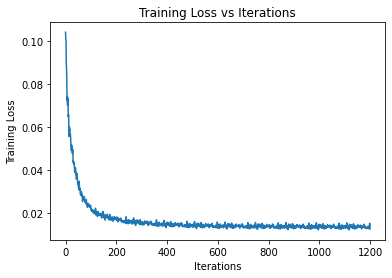

In [47]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_hid1))
plt.plot(xtrainloss,trainingloss_list_hid1)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

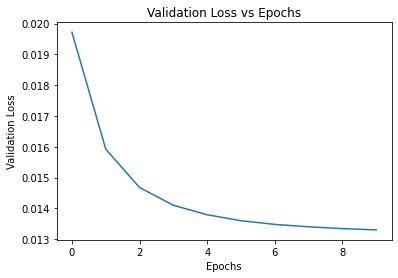

In [42]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_hid1))
plt.plot(xtestloss,validationloss_list_hid1)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [116]:
# Reconstruction Accuracy on Train and Test Data
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp = model_hid1(X.float())
        train_loss_new += criterion_hid1(temp,X)
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp = model_hid1(X.float())
        test_loss_new += criterion_hid1(temp, X)
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 2.7508227503858507e-05
Reconstruction Error on Test Data = 2.7315803890815005e-05


#### **No. of Hidden layer is 128**

In [49]:
model_hid2=AE_hid(128)
print(model_hid2)

AE_hid(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [50]:
criterion_hid2 = nn.MSELoss()
optimizer_hid2 = torch.optim.Adam(model_hid2.parameters(), lr=LearningRate)
test_loss_hid2 =0
trainingloss_list_hid2 = []
validationloss_list_hid2= []
validationaccuracy_list_hid2 = []

for epoch in range(epochs):
  print('Epoch:', epoch + 1)
  for images, labels in tqdm(trainloader):
    images=images.reshape(500,784)
    outputs = model_hid2(images.float())
    loss = criterion_hid2(outputs, images)
    trainingloss_list_hid2.append(loss.item())
    optimizer_hid2.zero_grad()
    loss.backward()
    optimizer_hid2.step()
    #trainingloss_list_hid2.append(loss.item())  
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs = model_hid2(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_hid2(outputs, images)
        test_loss_hid2    += loss/test_length
  validationloss_list_hid2.append(loss.item())  

Epoch: 1


100%|██████████| 20/20 [00:01<00:00, 15.08it/s]


Epoch: 2


100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch: 3


100%|██████████| 20/20 [00:01<00:00, 16.68it/s]


Epoch: 4


100%|██████████| 20/20 [00:01<00:00, 16.19it/s]


Epoch: 5


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


Epoch: 6


100%|██████████| 20/20 [00:01<00:00, 16.52it/s]


Epoch: 7


100%|██████████| 20/20 [00:01<00:00, 17.36it/s]


Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 16.50it/s]


Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 11.47it/s]


Epoch: 10


100%|██████████| 20/20 [00:01<00:00, 16.84it/s]


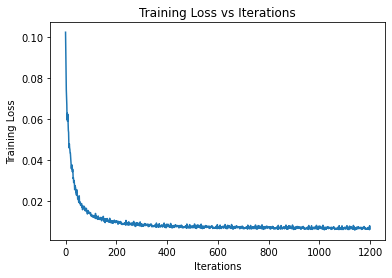

In [52]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_hid2))
plt.plot(xtrainloss,trainingloss_list_hid2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

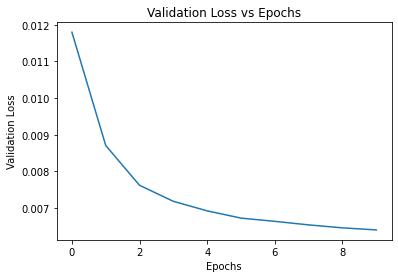

In [51]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_hid2))
plt.plot(xtestloss,validationloss_list_hid2)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [115]:
# Reconstruction Accuracy on Train and Test Data
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp = model_hid2(X.float())
        train_loss_new += criterion_hid2(temp,X)
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp = model_hid2(X.float())
        test_loss_new += criterion_hid2(temp, X)
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.347863144474104e-05
Reconstruction Error on Test Data = 1.3364959158934653e-05


#### **No. of Hidden layer is 256**

In [53]:
model_hid3=AE_hid(256)
print(model_hid3)

AE_hid(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [54]:
model_hid3=AE_hid(256)
criterion_hid3 = nn.MSELoss()
optimizer_hid3= torch.optim.Adam(model_hid3.parameters(), lr=LearningRate)
test_loss_hid3 =0
trainingloss_list_hid3 = []
validationloss_list_hid3= []
validationaccuracy_list_hid3 = []

for epoch in range(epochs):
  print('Epoch:', epoch + 1)
  for images, labels in tqdm(trainloader):
    images=images.reshape(500,784)
    outputs = model_hid3(images.float())
    loss = criterion_hid3(outputs, images)
    trainingloss_list_hid3.append(loss.item())
    optimizer_hid3.zero_grad()
    loss.backward()
    optimizer_hid3.step()
    #trainingloss_list_hid3.append(loss.item())  
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs = model_hid3(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_hid3(outputs, images)
        test_loss_hid3    += loss/test_length
  validationloss_list_hid3.append(loss.item())     


Epoch: 1


100%|██████████| 20/20 [00:01<00:00, 14.68it/s]


Epoch: 2


100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


Epoch: 3


100%|██████████| 20/20 [00:01<00:00, 15.70it/s]


Epoch: 4


100%|██████████| 20/20 [00:01<00:00, 11.50it/s]


Epoch: 5


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


Epoch: 6


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


Epoch: 7


100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 16.41it/s]


Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 16.65it/s]


Epoch: 10


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


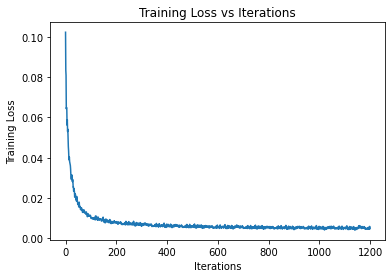

In [55]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_hid3))
plt.plot(xtrainloss,trainingloss_list_hid3)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

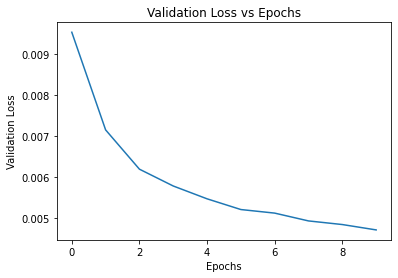

In [56]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_hid3))
plt.plot(xtestloss,validationloss_list_hid3)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [117]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp = model_hid3(X.float())
        train_loss_new += criterion_hid3(temp,X)
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp = model_hid3(X.float())
        test_loss_new += criterion_hid3(temp, X)
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.0035778359451797e-05
Reconstruction Error on Test Data = 9.983924428524915e-06


#### Visualising the reconstruction for different values of x



 For Image :  0


<Figure size 432x288 with 0 Axes>

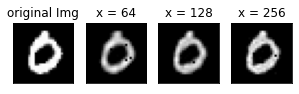



 For Image :  1


<Figure size 432x288 with 0 Axes>

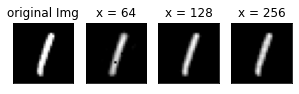



 For Image :  2


<Figure size 432x288 with 0 Axes>

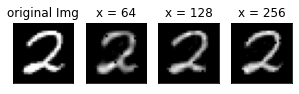



 For Image :  3


<Figure size 432x288 with 0 Axes>

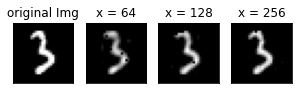



 For Image :  4


<Figure size 432x288 with 0 Axes>

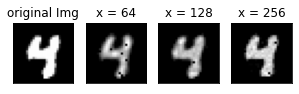



 For Image :  5


<Figure size 432x288 with 0 Axes>

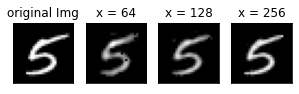



 For Image :  6


<Figure size 432x288 with 0 Axes>

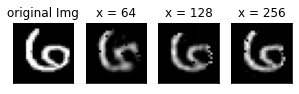



 For Image :  7


<Figure size 432x288 with 0 Axes>

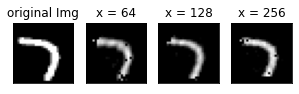



 For Image :  8


<Figure size 432x288 with 0 Axes>

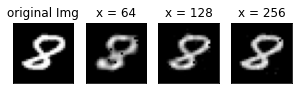



 For Image :  9


<Figure size 432x288 with 0 Axes>

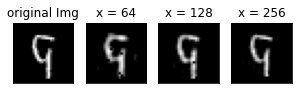

In [57]:
for i in range(10):

    print()
    print("\n For Image : ", i)
    output1=model_hid1(imageset[i].reshape(1,784).float())
    output2=model_hid2(imageset[i].reshape(1,784).float())
    output3=model_hid3(imageset[i].reshape(1,784).float())
    plt.figure(1)
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (5, 5))
    ax1.set_xticks([])
    ax1.set_yticks([])
    im=ax1.imshow(imageset[i],cmap='gray')

    ax2.set_xticks([])
    ax2.set_yticks([])
    im=ax2.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax3.set_xticks([])
    ax3.set_yticks([])
    im=ax3.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax4.set_xticks([])
    ax4.set_yticks([])
    im=ax4.imshow(output3.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax1.title.set_text('original Img')
    ax2.title.set_text('x = 64')
    ax3.title.set_text('x = 128')
    ax4.title.set_text('x = 256')

    plt.show()
    i+=1

#### Passing a random noise image or Non Digit through the network

<Figure size 432x288 with 0 Axes>

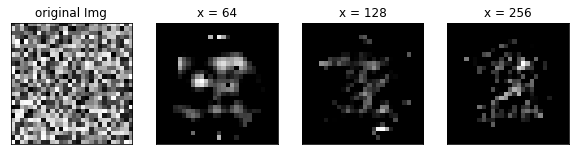

In [58]:
X = torch.rand(1,28,28)
output1=model_hid1(X.reshape(1,784).float())
output2=model_hid2(X.reshape(1,784).float())
output3=model_hid3(X.reshape(1,784).float())
plt.figure(1)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (10,10))

ax1.set_xticks([])
ax1.set_yticks([])
im=ax1.imshow(X.detach().numpy()[0],cmap='gray')

ax2.set_xticks([])
ax2.set_yticks([])
im=ax2.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray')

ax3.set_xticks([])
ax3.set_yticks([])
im=ax3.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray')

ax4.set_xticks([])
ax4.set_yticks([])
im=ax4.imshow(output3.detach().numpy()[0].reshape(28,28),cmap='gray')

ax1.title.set_text('original Img')
ax2.title.set_text('x = 64')
ax3.title.set_text('x = 128')
ax4.title.set_text('x = 256')
plt.show()

# 3. Sparse AutoEncoder

In [59]:
class AE_sa(nn.Module):
  def __init__(self):
    super(AE_sa, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1225),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1225,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    l1loss=torch.norm(x,p=1)
    x=self.decoder(x)
    return x,l1loss   

In [60]:
LearningRate=0.0003
lam = 1e-7
epochs=10
model_sa=AE_sa()
print(model_sa)

AE_sa(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1225, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1225, out_features=784, bias=True)
    (1): ReLU()
  )
)


In [62]:
criterion_sa = nn.MSELoss()
optimizer_sa = torch.optim.Adam(model_sa.parameters(), lr=LearningRate)
test_loss_sa = 0 
trainingloss_list_sa= []
validationloss_list_sa = []
validationaccuracy_list_sa = []

for epoch in range(epochs):
  print('Epoch:', epoch + 1)
  for images, labels in tqdm(trainloader):
    images=images.reshape(500,784)
    outputs,loss1 = model_sa(images.float())
    loss = criterion_sa(outputs, images)+lam*loss1
    trainingloss_list_sa.append(loss.item())
    optimizer_sa.zero_grad()
    loss.backward()
    optimizer_sa.step()
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs,loss1 = model_sa(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_sa(outputs, images) + lam*loss1
        test_loss_sa    += loss/test_length
  validationloss_list_sa.append(loss.item())   


Epoch: 1


100%|██████████| 20/20 [00:01<00:00, 10.83it/s]


Epoch: 2


100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


Epoch: 3


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Epoch: 4


100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


Epoch: 5


100%|██████████| 20/20 [00:03<00:00,  5.92it/s]


Epoch: 6


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Epoch: 7


100%|██████████| 20/20 [00:01<00:00, 10.86it/s]


Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 11.00it/s]


Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 11.07it/s]


Epoch: 10


100%|██████████| 20/20 [00:01<00:00, 10.56it/s]


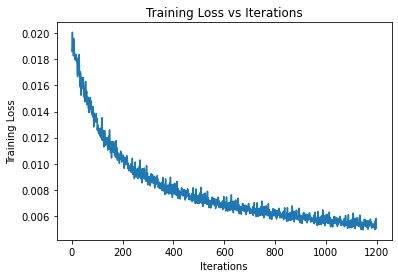

In [63]:
plt.figure(1)
xtrainloss5 = np.arange(len(trainingloss_list_sa))
plt.plot(xtrainloss5,trainingloss_list_sa)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

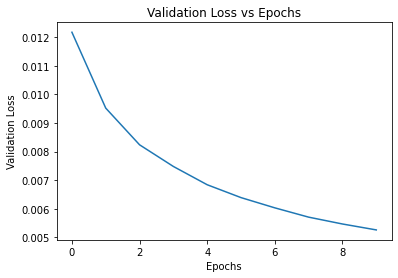

In [64]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_sa))
plt.plot(xtestloss,validationloss_list_sa)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [119]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp,loss1 = model_sa(X.float())
        train_loss_new += criterion_sa(temp,X) + lam*loss1
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp,loss1 = model_sa(X.float())
        test_loss_new += criterion_sa(temp, X) + lam*loss1
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.0627726624079514e-05
Reconstruction Error on Test Data = 1.087658074538922e-05




 For Image :  0


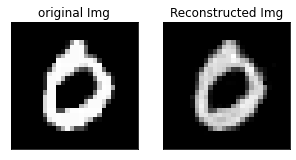



 For Image :  1


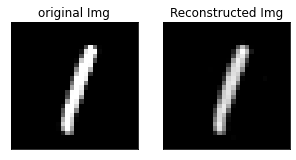



 For Image :  2


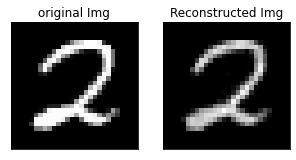



 For Image :  3


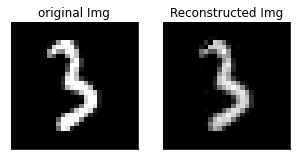



 For Image :  4


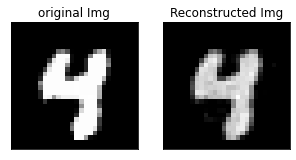



 For Image :  5


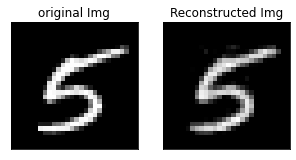



 For Image :  6


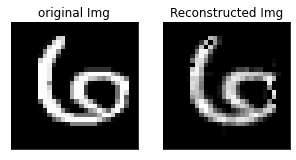



 For Image :  7


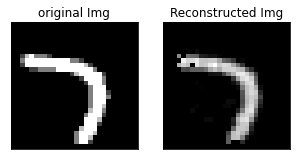



 For Image :  8


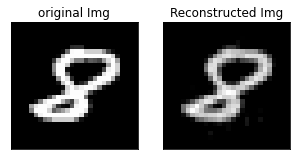



 For Image :  9


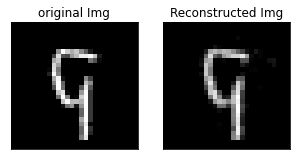

In [65]:
for i in range(10):
    print()
    print("\n For Image : ", i)
    output,loss=model_sa(imageset[i].reshape(1,784))
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (5, 5))
    ax1.set_xticks([])
    ax1.set_yticks([])
    im = ax1.imshow(imageset[i],cmap='gray')

    ax2.set_xticks([])
    ax2.set_yticks([])
    im = ax2.imshow(output.detach().numpy()[0].reshape(28,28),cmap='gray') 
    ax1.title.set_text('original Img')
    ax2.title.set_text('Reconstructed Img')
    
    plt.show()

#### Comparing the average hidden layer activation of Sparse AE with Standard AE

In [66]:
print("Average hidden layer activations for random 10 images")
sum=0
for i in range(10):
  avg=torch.norm(model_hid3.encoder(imageset[i].reshape(1,784)),p=1)/256.0
  print(avg.detach().numpy())
  sum+=avg.detach().numpy()
print("Average of these values for Standard AE",sum/10.0)

Average hidden layer activations for random 10 images
0.7489022
0.42055807
0.55895174
0.5134212
0.9115867
0.5330092
0.7373317
0.5845259
0.6613664
0.37586528
Average of these values for Standard AE 0.6045518308877945


In [67]:
print("Average hidden layer activations for random 10 images")
sum=0
for i in range(10):
  avg=torch.norm(model_sa.encoder(imageset[i].reshape(1,784)),p=1)/1225.0
  print(avg.detach().numpy())
  sum+=avg.detach().numpy()
print("Average of these values for Sparse AE",sum/10.0)

Average hidden layer activations for random 10 images
0.043345917
0.022421747
0.0538867
0.03830733
0.04533722
0.042692274
0.059231114
0.047327276
0.04868181
0.036476824
Average of these values for Sparse AE 0.043770821392536165


#### Visualising the learned filters of Sparse AE and the Standard AE

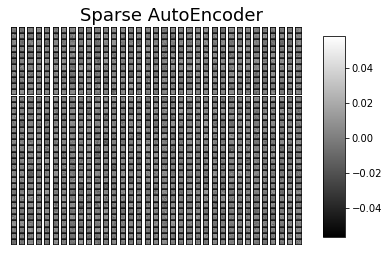

In [68]:
### Sparse AutoEncoder 
ix=1
fig,ax=plt.subplots()
fig.suptitle("Sparse AutoEncoder", fontsize=18, y=0.95)
for i in range(len(model_sa.state_dict()['encoder.0.weight'])):
  ax=plt.subplot(35,35,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(model_sa.state_dict()['encoder.0.weight'][i].reshape(28,28),cmap='gray')
  ix+=1
  
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

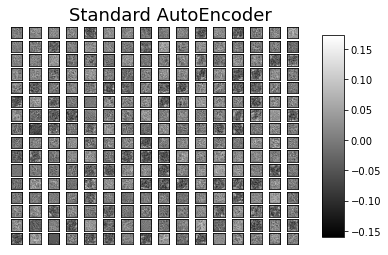

In [69]:
#### Standard AutoEncoder
ix=1
fig,ax=plt.subplots()
fig.suptitle("Standard AutoEncoder", fontsize=18, y=0.95)
for i in range(len(model_hid3.state_dict()['encoder.0.weight'])):
  ax=plt.subplot(16,16,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(model_hid3.state_dict()['encoder.0.weight'][i].reshape(28,28),cmap='gray')
  ix+=1
  
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

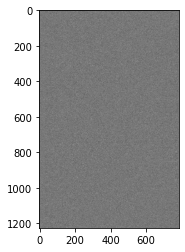

In [70]:
plt.imshow(model_sa.state_dict()['encoder.0.weight'],cmap='gray')

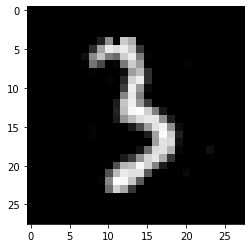

In [71]:
a=random.sample(range(0,784),int(0.9*784))
X=imageset[3].clone()
X=X.reshape(1,784)
X[0][a]=0
output1=model_hid3(imageset[3].reshape(1,784))
plt.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray') 


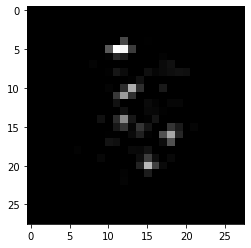

In [72]:
output2=model_hid3(X.reshape(1,784))
plt.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray') 

# 4. Denoising AE

#### Passing corrupted images to the Standard AE from Q2

In [73]:
def Add_Noise(image, noise_val = 0.3 ): #adding salt and pepper noise 

    noise = torch.randn(image.size())*noise_val
    noisy_image = image + noise
    return noisy_image


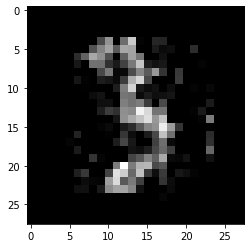

In [74]:
X=imageset[3].clone()
Y=Add_Noise(X,0.3)
Y=Y.reshape(1,784)
output1=model_hid3(Y)
plt.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray') 

#### Designing Denoising Encoder for different noise level and compare with Standard AE

**Denoising AE For Noise Level 0.3**

In [75]:
LearningRate=0.0003
epochs=10

In [76]:
noise_val = 0.3
model_dae=AE_sa()
criterion_dae = nn.MSELoss()
optimizer_dae = torch.optim.Adam(model_dae.parameters(), lr=LearningRate)
test_loss_dae = 0
trainingloss_list_dae = []
validationloss_list_dae = []
validationaccuracy_list_dae= []

for epoch in range(epochs):
  print('Epoch',epoch+1,':')
  for images, labels in tqdm(trainloader):
    noisy_data = Add_Noise(images, noise_val)
    noisy_data=noisy_data.reshape(500,784)
    outputs,loss1 = model_dae(noisy_data.float())
    loss = criterion_dae(outputs, flatten(images,1))
    trainingloss_list_dae.append(loss.item())
    optimizer_dae.zero_grad()
    loss.backward()
    optimizer_dae.step()
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs,loss1 = model_dae(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_dae(outputs, flatten(images,1))
        test_loss_dae   += loss/test_length
  validationloss_list_dae.append(loss.item())   
  

Epoch 1 :


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 2 :


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 3 :


100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


Epoch 4 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


Epoch 5 :


100%|██████████| 20/20 [00:01<00:00, 11.30it/s]


Epoch 6 :


100%|██████████| 20/20 [00:01<00:00, 11.06it/s]


Epoch 7 :


100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Epoch 8 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


Epoch 9 :


100%|██████████| 20/20 [00:01<00:00, 11.04it/s]


Epoch 10 :


100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


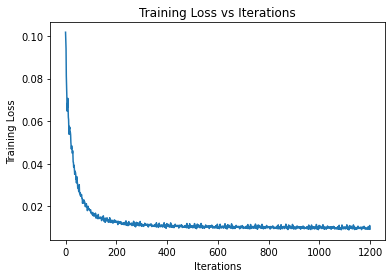

In [78]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_dae))
plt.plot(xtrainloss,trainingloss_list_dae)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

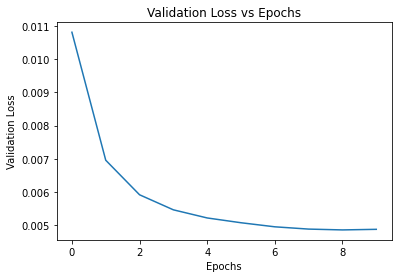

In [77]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_dae))
plt.plot(xtestloss,validationloss_list_dae)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [120]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae(X.float())
        train_loss_new += criterion_dae(temp,flatten(X,1)) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae(X.float())
        test_loss_new += criterion_dae(temp, flatten(X,1)) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.0876998203457333e-05
Reconstruction Error on Test Data = 1.064356547431089e-05


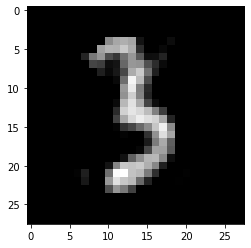

In [79]:
output2,loss2=model_dae(Y)
plt.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray') 

**Denoising AE For Noise Level 0.5**

In [80]:
noise_val = 0.5
model_dae1=AE_sa()
criterion_dae1 = nn.MSELoss()
optimizer_dae1 = torch.optim.Adam(model_dae1.parameters(), lr=LearningRate)
test_loss_dae1 = 0
trainingloss_list_dae1 = []
validationloss_list_dae1 = []
validationaccuracy_list_dae1= []

for epoch in range(epochs):
  print('Epoch',epoch+1,':')
  for images, labels in tqdm(trainloader):
    noisy_data = Add_Noise(images, noise_val)
    noisy_data=noisy_data.reshape(500,784)
    outputs,loss1 = model_dae1(noisy_data.float())
    loss = criterion_dae1(outputs, flatten(images,1))
    trainingloss_list_dae1.append(loss.item())
    optimizer_dae1.zero_grad()
    loss.backward()
    optimizer_dae1.step()
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs,loss1 = model_dae1(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_dae1(outputs, flatten(images,1))
        test_loss_dae1   += loss/test_length
  validationloss_list_dae1.append(loss.item())   
  

Epoch 1 :


100%|██████████| 20/20 [00:01<00:00, 11.13it/s]


Epoch 2 :


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Epoch 3 :


100%|██████████| 20/20 [00:01<00:00, 11.09it/s]


Epoch 4 :


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Epoch 5 :


100%|██████████| 20/20 [00:01<00:00, 10.93it/s]


Epoch 6 :


100%|██████████| 20/20 [00:03<00:00,  5.67it/s]


Epoch 7 :


100%|██████████| 20/20 [00:01<00:00, 11.03it/s]


Epoch 8 :


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


Epoch 9 :


100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Epoch 10 :


100%|██████████| 20/20 [00:01<00:00, 10.70it/s]


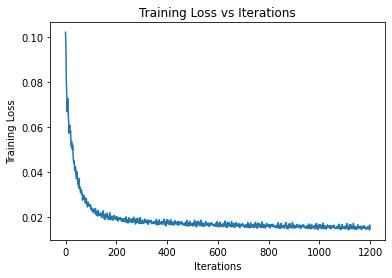

In [81]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_dae1))
plt.plot(xtrainloss,trainingloss_list_dae1)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

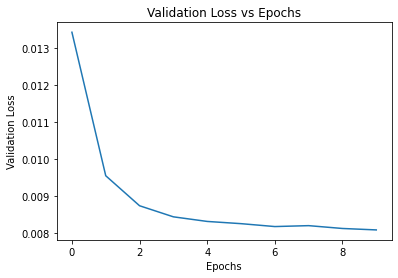

In [82]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_dae1))
plt.plot(xtestloss,validationloss_list_dae1)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [121]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae1(X.float())
        train_loss_new += criterion_dae1(temp,flatten(X,1)) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae1(X.float())
        test_loss_new += criterion_dae1(temp, flatten(X,1)) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.6901802155189216e-05
Reconstruction Error on Test Data = 1.6560807125642896e-05


**Denoising AE For Noise 0.8**

In [84]:
noise_val = 0.8
model_dae2=AE_sa()
criterion_dae2 = nn.MSELoss()
optimizer_dae2 = torch.optim.Adam(model_dae2.parameters(), lr=LearningRate)
test_loss_dae2 = 0
trainingloss_list_dae2 = []
validationloss_list_dae2 = []
validationaccuracy_list_dae2= []

for epoch in range(epochs):
  print('Epoch',epoch+1,':')
  for images, labels in tqdm(trainloader):
    noisy_data = Add_Noise(images, noise_val)
    noisy_data=noisy_data.reshape(500,784)
    outputs,loss1 = model_dae2(noisy_data.float())
    loss = criterion_dae2(outputs, flatten(images,1))
    trainingloss_list_dae2.append(loss.item())
    optimizer_dae2.zero_grad()
    loss.backward()
    optimizer_dae2.step()
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs,loss1 = model_dae2(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_dae2(outputs, flatten(images,1))
        test_loss_dae2  += loss/test_length
  validationloss_list_dae2.append(loss.item())    

Epoch 1 :


100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Epoch 2 :


100%|██████████| 20/20 [00:01<00:00, 11.04it/s]


Epoch 3 :


100%|██████████| 20/20 [00:01<00:00, 11.32it/s]


Epoch 4 :


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Epoch 5 :


100%|██████████| 20/20 [00:01<00:00, 11.26it/s]


Epoch 6 :


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch 7 :


100%|██████████| 20/20 [00:01<00:00, 11.35it/s]


Epoch 8 :


100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


Epoch 9 :


100%|██████████| 20/20 [00:01<00:00, 11.29it/s]


Epoch 10 :


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


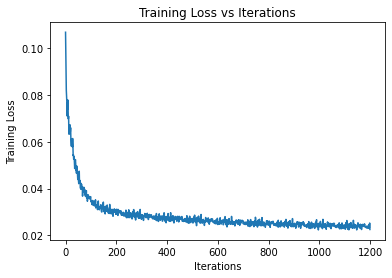

In [85]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_dae2))
plt.plot(xtrainloss,trainingloss_list_dae2)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

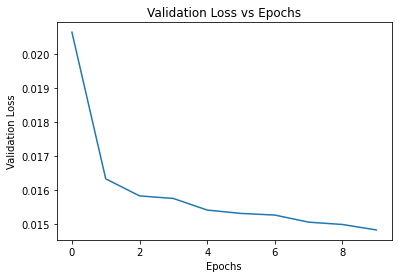

In [86]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_dae2))
plt.plot(xtestloss,validationloss_list_dae2)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [122]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae2(X.float())
        train_loss_new += criterion_dae2(temp,flatten(X,1)) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae2(X.float())
        test_loss_new += criterion_dae2(temp, flatten(X,1)) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 3.0424098440562375e-05
Reconstruction Error on Test Data = 3.010603177244775e-05


**Denoising AE For Noise 0.9**

In [87]:
noise_val = 0.9
model_dae3=AE_sa()
criterion_dae3 = nn.MSELoss()
optimizer_dae3 = torch.optim.Adam(model_dae3.parameters(), lr=LearningRate)
test_loss_dae3 = 0
trainingloss_list_dae3 = []
validationloss_list_dae3= []
validationaccuracy_list_dae3= []

for epoch in range(epochs):
  print('Epoch',epoch+1,':')
  for images, labels in tqdm(trainloader):
    noisy_data = Add_Noise(images, noise_val)
    noisy_data=noisy_data.reshape(500,784)
    outputs,loss1 = model_dae3(noisy_data.float())
    loss = criterion_dae3(outputs, flatten(images,1))
    trainingloss_list_dae3.append(loss.item())
    optimizer_dae3.zero_grad()
    loss.backward()
    optimizer_dae3.step()
  for images, labels in tqdm(testloader):
    with torch.no_grad():
        images=images.reshape(500,784)
        outputs,loss1 = model_dae3(images.float())
        #_,predicted=torch.max(outputs.data, 1)
        loss = criterion_dae3(outputs, flatten(images,1))
        test_loss_dae3  += loss/test_length
  validationloss_list_dae3.append(loss.item())   

Epoch 1 :


100%|██████████| 20/20 [00:01<00:00, 11.02it/s]


Epoch 2 :


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]


Epoch 3 :


100%|██████████| 20/20 [00:01<00:00, 11.24it/s]


Epoch 4 :


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 5 :


100%|██████████| 20/20 [00:01<00:00, 11.25it/s]


Epoch 6 :


100%|██████████| 20/20 [00:01<00:00, 11.04it/s]


Epoch 7 :


100%|██████████| 20/20 [00:01<00:00, 10.81it/s]


Epoch 8 :


100%|██████████| 20/20 [00:01<00:00, 11.12it/s]


Epoch 9 :


100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


Epoch 10 :


100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


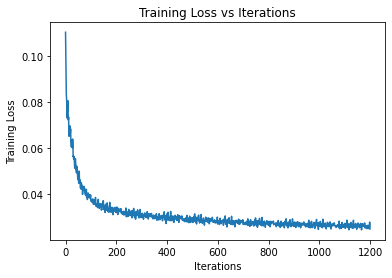

In [88]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_dae3))
plt.plot(xtrainloss,trainingloss_list_dae3)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.show()

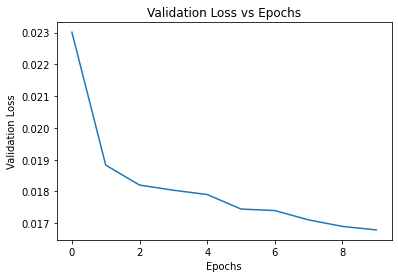

In [89]:
plt.figure(1)
xtestloss=np.arange(len(validationloss_list_dae3))
plt.plot(xtestloss,validationloss_list_dae3)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

In [123]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae3(X.float())
        train_loss_new += criterion_dae3(temp,flatten(X,1)) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        X=X.reshape(500,784)
        temp,loss1 = model_dae3(X.float())
        test_loss_new += criterion_dae3(temp, flatten(X,1)) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 3.432848461670801e-05
Reconstruction Error on Test Data = 3.391372229089029e-05


#### **Variations Observation between different noise level**

<Figure size 432x288 with 0 Axes>

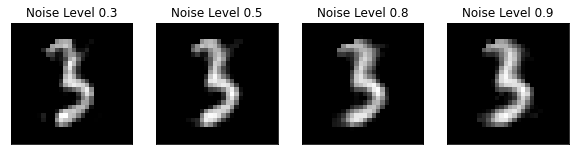

In [90]:
output,loss=model_dae(Y)
output1,loss1=model_dae1(Y)
output2,loss2=model_dae2(Y)
output3,loss3=model_dae3(Y)

plt.figure(1)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (10,10))

ax1.set_xticks([])
ax1.set_yticks([])
im=ax1.imshow(output.detach().numpy()[0].reshape(28,28),cmap='gray')

ax2.set_xticks([])
ax2.set_yticks([])
im=ax2.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray')

ax3.set_xticks([])
ax3.set_yticks([])
im=ax3.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray')

ax4.set_xticks([])
ax4.set_yticks([])
im=ax4.imshow(output3.detach().numpy()[0].reshape(28,28),cmap='gray')

ax1.title.set_text('Noise Level 0.3')
ax2.title.set_text('Noise Level 0.5')
ax3.title.set_text('Noise Level 0.8')
ax4.title.set_text('Noise Level 0.9')
plt.show()


#### Visualising the learned filters for Denoising AE

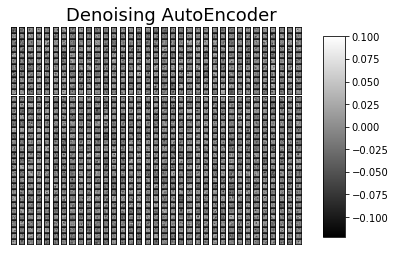

In [91]:
### Denoising AutoEncoder with noise level 0.9
ix=1
fig,ax=plt.subplots()
fig.suptitle("Denoising AutoEncoder", fontsize=18, y=0.95)
for i in range(len(model_dae3.state_dict()['encoder.0.weight'])):
  ax=plt.subplot(35,35,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(model_dae3.state_dict()['encoder.0.weight'][i].reshape(28,28),cmap='gray')
  ix+=1
  
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

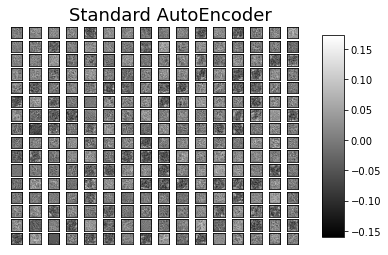

In [92]:
#### Standard AutoEncoder
ix=1
fig,ax=plt.subplots()
fig.suptitle("Standard AutoEncoder", fontsize=18, y=0.95)
for i in range(len(model_hid3.state_dict()['encoder.0.weight'])):
  ax=plt.subplot(16,16,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(model_hid3.state_dict()['encoder.0.weight'][i].reshape(28,28),cmap='gray')
  ix+=1
  
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# 5.Convolutional AE

#### AE_Unpool

In [133]:
class AE_unpool(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input
    
    def __init__(self): #class constructor
        super(AE_unpool,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #7x7x16 to 3x3x16
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #28x28x8 to 28x28x1
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([500, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1

        
        return reconstructed_input,encoded_input

In [134]:
LearningRate=0.01
epochs=10
model_unpool=AE_unpool()
print(model_unpool)

AE_unpool(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): Identity()
  )
  (decoder_conv2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (unpool): MaxUnpool2d(kern

In [135]:
criterion_con1 = nn.MSELoss()
optimizer_con1 = torch.optim.Adam(model_unpool.parameters(), lr=LearningRate)
trainingloss_list_con1= []
validationloss_list_con1 = []
test_loss_con1 = 0

for epoch in range(epochs):
  print('Epoch',epoch+1)
  for images, labels in tqdm(trainloader):
    reconstructed_input,encoded_input =model_unpool(images.float())
    loss= criterion_con1(reconstructed_input, images)
    trainingloss_list_con1.append(loss.item())
    optimizer_con1.zero_grad()
    loss.backward()
    optimizer_con1.step()



Epoch 1


100%|██████████| 120/120 [00:36<00:00,  3.29it/s]


Epoch 2


100%|██████████| 120/120 [00:35<00:00,  3.39it/s]


Epoch 3


100%|██████████| 120/120 [00:36<00:00,  3.32it/s]


Epoch 4


100%|██████████| 120/120 [00:36<00:00,  3.33it/s]


Epoch 5


100%|██████████| 120/120 [00:36<00:00,  3.25it/s]


Epoch 6


100%|██████████| 120/120 [00:35<00:00,  3.35it/s]


Epoch 7


100%|██████████| 120/120 [00:34<00:00,  3.46it/s]


Epoch 8


100%|██████████| 120/120 [00:35<00:00,  3.36it/s]


Epoch 9


100%|██████████| 120/120 [00:36<00:00,  3.30it/s]


Epoch 10


100%|██████████| 120/120 [00:35<00:00,  3.41it/s]


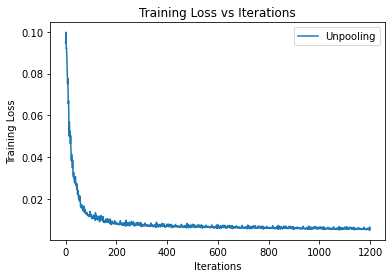

In [136]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_con1))
plt.plot(xtrainloss,trainingloss_list_con1,label="Unpooling")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

In [137]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        temp,loss1 = model_unpool(X.float())
        train_loss_new += criterion_con1(temp,X) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        temp,loss1 = model_unpool(X.float())
        test_loss_new += criterion_con1(temp, X) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 1.1278763849986717e-05
Reconstruction Error on Test Data = 1.132055331254378e-05


#### AE_Deconvolution

In [138]:
class conv_AE_deconv(nn.Module):
    def __init__(self): #class constructor
        super(conv_AE_deconv,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input     = self.decoder_conv1(encoded_input)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input


In [139]:
model_deconv= conv_AE_deconv()
print(model_deconv)

conv_AE_deconv(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (decoder_conv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=

In [140]:
#model_con2=AE_con(2)
model_deconv= conv_AE_deconv()
criterion_con2 = nn.MSELoss()
optimizer_con2 = torch.optim.Adam(model_deconv.parameters(), lr=LearningRate)
trainingloss_list_con2 = []
validationloss_list_con2 = []
test_loss_con2 = 0

for epoch in range(epochs):
  print('Epoch',epoch+1)
  for images, labels in tqdm(trainloader):
    #print(images.shape)
    optimizer_con2.zero_grad()
    reconstructed_input,encoded_input = model_deconv(images)
    loss = criterion_con2(reconstructed_input, images)
    trainingloss_list_con2.append(loss.item())
    #optimizer_con2.zero_grad()
    loss.backward()
    optimizer_con2.step()
  
  

Epoch 1


100%|██████████| 120/120 [00:54<00:00,  2.22it/s]


Epoch 2


100%|██████████| 120/120 [00:32<00:00,  3.69it/s]


Epoch 3


100%|██████████| 120/120 [00:33<00:00,  3.57it/s]


Epoch 4


100%|██████████| 120/120 [00:33<00:00,  3.61it/s]


Epoch 5


100%|██████████| 120/120 [00:32<00:00,  3.73it/s]


Epoch 6


100%|██████████| 120/120 [00:33<00:00,  3.63it/s]


Epoch 7


100%|██████████| 120/120 [00:32<00:00,  3.73it/s]


Epoch 8


100%|██████████| 120/120 [00:33<00:00,  3.63it/s]


Epoch 9


100%|██████████| 120/120 [00:32<00:00,  3.69it/s]


Epoch 10


100%|██████████| 120/120 [00:35<00:00,  3.37it/s]


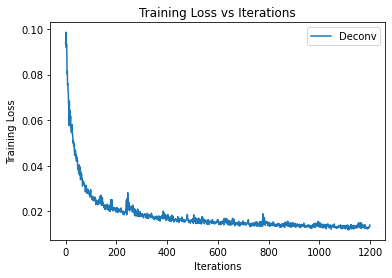

In [141]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_con2))
plt.plot(xtrainloss,trainingloss_list_con2,label="Deconv")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

In [142]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        temp,loss1 = model_deconv(X.float())
        train_loss_new += criterion_con2(temp,X) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        temp,loss1 = model_deconv(X.float())
        test_loss_new += criterion_con2(temp, X) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 3.130066761514172e-05
Reconstruction Error on Test Data = 3.091134567512199e-05


#### AE_Deconvolution_Unpooling

In [143]:
class AE_deconv_unpool(nn.Module):
    def __init__(self): #class constructor
        super(AE_deconv_unpool,self).__init__() #calls the parent constructor
        
         #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([500, 16, 7, 7]))
        reconstructed_input     = self.decoder_conv1(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices2)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices1)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)
        
        
        return reconstructed_input,encoded_input        

In [144]:
model_deconv_unpool = AE_deconv_unpool()
print(model_deconv_unpool)

AE_deconv_unpool(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): ConvTranspose2d(

In [145]:
criterion_con3 = nn.MSELoss()
optimizer_con3 = torch.optim.Adam(model_deconv_unpool.parameters(), lr=LearningRate)
trainingloss_list_con3= []
validationloss_list_con3 = []
test_loss_con3 = 0

for epoch in range(epochs):
  print('Epoch',epoch+1)
  for images, labels in tqdm(trainloader):
    #print(images.shape)
    optimizer_con3.zero_grad()
    reconstructed_input,encoded_input = model_deconv_unpool(images)
    loss = criterion_con3(reconstructed_input, images)
    trainingloss_list_con3.append(loss.item())
    #optimizer_con2.zero_grad()
    loss.backward()
    optimizer_con3.step()
    

Epoch 1


100%|██████████| 120/120 [00:45<00:00,  2.64it/s]


Epoch 2


100%|██████████| 120/120 [00:45<00:00,  2.65it/s]


Epoch 3


100%|██████████| 120/120 [00:46<00:00,  2.57it/s]


Epoch 4


100%|██████████| 120/120 [00:46<00:00,  2.60it/s]


Epoch 5


100%|██████████| 120/120 [00:45<00:00,  2.62it/s]


Epoch 6


100%|██████████| 120/120 [00:47<00:00,  2.51it/s]


Epoch 7


100%|██████████| 120/120 [00:45<00:00,  2.65it/s]


Epoch 8


100%|██████████| 120/120 [00:45<00:00,  2.64it/s]


Epoch 9


100%|██████████| 120/120 [00:45<00:00,  2.64it/s]


Epoch 10


100%|██████████| 120/120 [00:46<00:00,  2.60it/s]


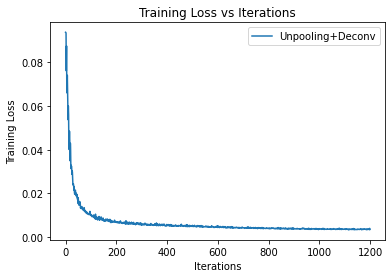

In [146]:
plt.figure(1)
xtrainloss=np.arange(len(trainingloss_list_con3))
plt.plot(xtrainloss,trainingloss_list_con3,label="Unpooling+Deconv")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()
plt.show()

In [147]:
size = len(trainloader.dataset)
train_loss_new = 0
with torch.no_grad():
    for X, y in trainloader:
        temp,loss1 = model_deconv_unpool(X.float())
        train_loss_new += criterion_con3(temp,X) 
train_loss_new /= size
print(f"Reconstruction Error on Train Data = {train_loss_new}")

size = len(testloader.dataset)
test_loss_new = 0
with torch.no_grad():
    for X, y in testloader:
        temp,loss1 = model_deconv_unpool(X.float())
        test_loss_new += criterion_con3(temp, X) 
test_loss_new /= size
print(f"Reconstruction Error on Test Data = {test_loss_new}")

Reconstruction Error on Train Data = 7.186134098446928e-06
Reconstruction Error on Test Data = 7.1576223490410484e-06


#### Visualising Reconstruction with different types of upsampling 

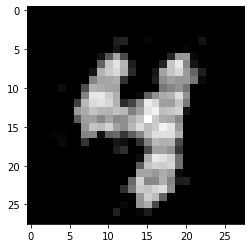

In [148]:
reconstructed_output,encoded_output=model_unpool(imageset[4].reshape(1,1,28,28))
plt.imshow(reconstructed_output.detach().numpy().reshape(28,28),cmap='gray') 

<Figure size 432x288 with 0 Axes>

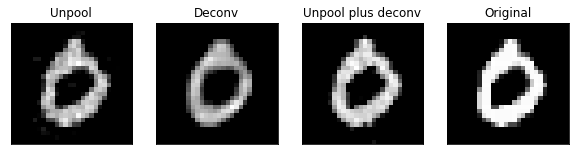

<Figure size 432x288 with 0 Axes>

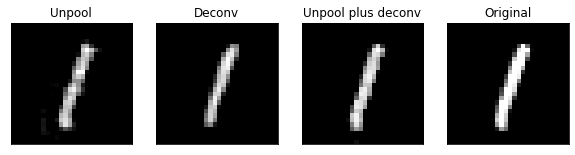

<Figure size 432x288 with 0 Axes>

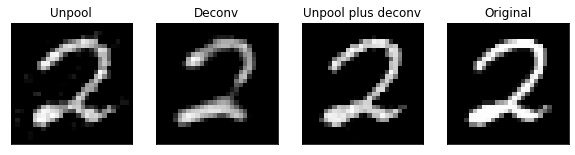

<Figure size 432x288 with 0 Axes>

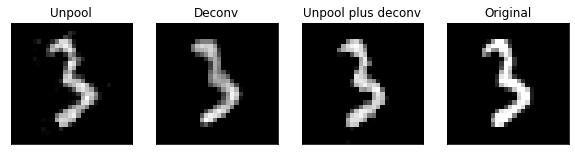

<Figure size 432x288 with 0 Axes>

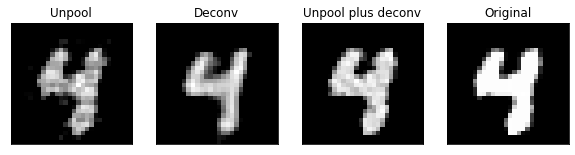

<Figure size 432x288 with 0 Axes>

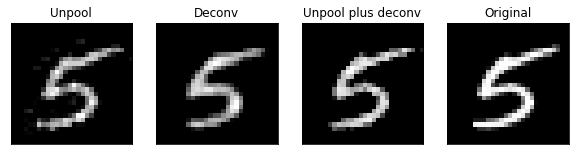

<Figure size 432x288 with 0 Axes>

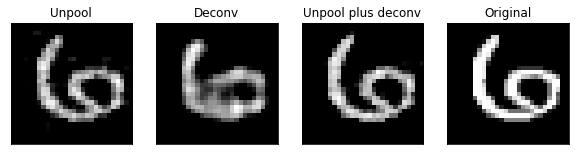

<Figure size 432x288 with 0 Axes>

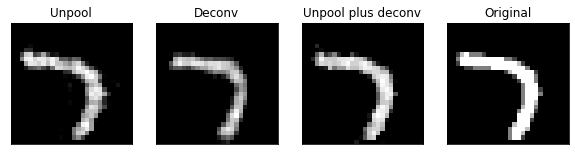

<Figure size 432x288 with 0 Axes>

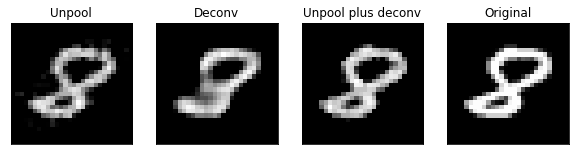

<Figure size 432x288 with 0 Axes>

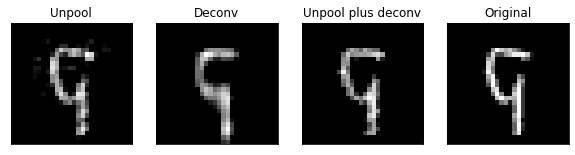

In [149]:
for i in range(10):

    output1,_=model_unpool(imageset[i].reshape(1,1,28,28))
    output2,_=model_deconv(imageset[i].reshape(1,1,28,28))
    output3,_=model_deconv_unpool(imageset[i].reshape(1,1,28,28))


    plt.figure(1)
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (10,10))

    ax1.set_xticks([])
    ax1.set_yticks([])
    im=ax1.imshow(output1.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax2.set_xticks([])
    ax2.set_yticks([])
    im=ax2.imshow(output2.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax3.set_xticks([])
    ax3.set_yticks([])
    im=ax3.imshow(output3.detach().numpy()[0].reshape(28,28),cmap='gray')

    ax4.set_xticks([])
    ax4.set_yticks([])
    im=ax4.imshow(imageset[i],cmap='gray')

    ax1.title.set_text('Unpool')
    ax2.title.set_text('Deconv')
    ax3.title.set_text('Unpool plus deconv')
    ax4.title.set_text('Original')
    plt.show()

    i+=1


#### Visualising the decoder weights 

**Unpooling**

torch.Size([16, 3, 3])
torch.Size([3, 12, 42])


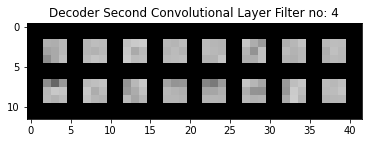

torch.Size([16, 3, 3])
torch.Size([3, 12, 42])


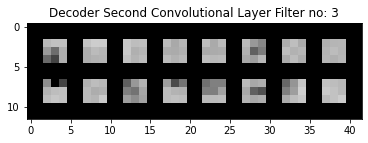

torch.Size([16, 3, 3])
torch.Size([3, 12, 42])


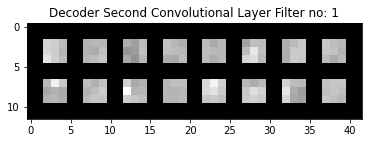

torch.Size([1, 8, 3, 3])


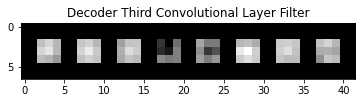

In [153]:
conv_2_filter = model_unpool.decoder_conv2[0].weight.detach().clone() 
conv_2_filter -= conv_2_filter.min()
conv_2_filter /= conv_2_filter.max()
filt_ind = np.random.randint(0 ,conv_2_filter.size()[0],3)
for ind in filt_ind:  
    print(conv_2_filter[ind].size())
    image = make_grid(conv_2_filter[ind].reshape(16,1,3,3)) 
    print(image.size())
    image = image.permute(1,2,0) 
    plt.imshow(image)
    str_title = 'Decoder Second Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()

conv_3_filter = model_unpool.decoder_conv3[0].weight.detach().clone() 
conv_3_filter -= conv_3_filter.min()
conv_3_filter /= conv_3_filter.max()
print(conv_3_filter.size())
image= make_grid(conv_3_filter.reshape(8,1,3,3))
image= image.permute(1,2,0) 
plt.imshow(image)
str_title = 'Decoder Third Convolutional Layer Filter'
plt.title(str_title)
plt.show() 

**Deconvolution**

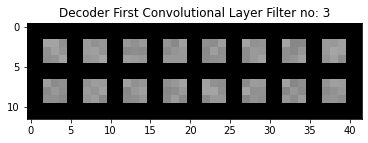

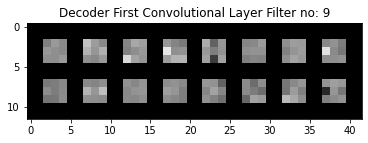

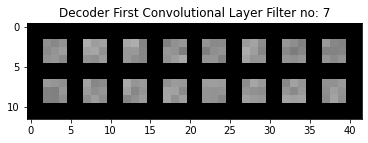

torch.Size([8, 4, 4])


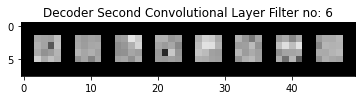

torch.Size([8, 4, 4])


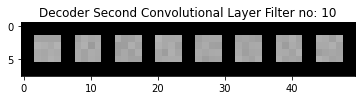

torch.Size([8, 4, 4])


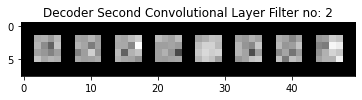

torch.Size([8, 1, 4, 4])


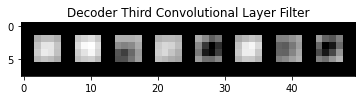

In [154]:
conv_1_filter = model_deconv.decoder_conv1[0].weight.detach().clone() 
conv_1_filter -= conv_1_filter.min()
conv_1_filter /= conv_1_filter.max()
filt_ind = np.random.randint(0 ,conv_1_filter.size()[0],3)
for ind in filt_ind:    
    image= make_grid(conv_1_filter[ind].reshape(16,1,3,3)) 
    image= image.permute(1,2,0) 
    plt.imshow(image)
    str_title = 'Decoder First Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()
    
conv_2_filter = model_deconv.decoder_conv2[0].weight.detach().clone() 
conv_2_filter -= conv_2_filter.min()
conv_2_filter /= conv_2_filter.max()
filt_ind = np.random.randint(0 ,conv_2_filter.size()[0],3)
for ind in filt_ind:   
    print(conv_2_filter[ind].size())

    image= make_grid(conv_2_filter[ind].reshape(8,1,4,4))
    image= image.permute(1,2,0) 
    plt.imshow(image)
    str_title = 'Decoder Second Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()

conv_3_filter = model_deconv.decoder_conv3[0].weight.detach().clone() 
conv_3_filter -= conv_3_filter.min()
conv_3_filter /= conv_3_filter.max()
print(conv_3_filter.size())

image = make_grid(conv_3_filter.reshape(8,1,4,4)) 
image = image.permute(1,2,0)
plt.imshow(image)
str_title = 'Decoder Third Convolutional Layer Filter'
plt.title(str_title)
plt.show()

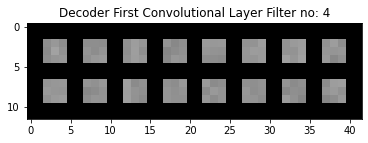

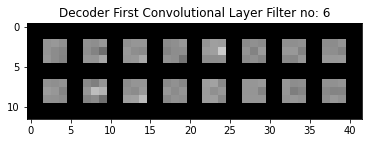

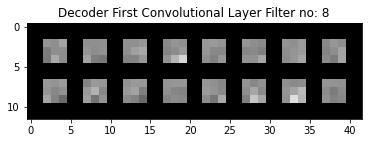

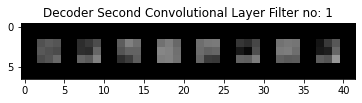

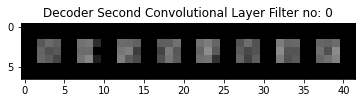

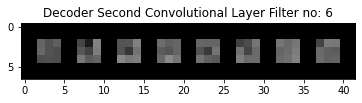

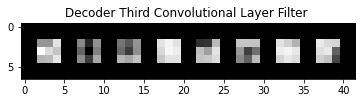

In [155]:
conv_1_filter = model_deconv_unpool.decoder_conv1[0].weight.detach().clone() 
conv_1_filter -= conv_1_filter.min()
conv_1_filter /= conv_1_filter.max()
filt_ind = np.random.randint(0 ,conv_1_filter.size()[0],3)
for ind in filt_ind:    
    image  = make_grid(conv_1_filter[ind].reshape(16,1,3,3)) 
    image  = image.permute(1,2,0) 
    plt.imshow(image)
    str_title = 'Decoder First Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()
    
conv_2_filter = model_deconv_unpool.decoder_conv2[0].weight.detach().clone() 
conv_2_filter -= conv_2_filter.min()
conv_2_filter /= conv_2_filter.max()
filt_ind = np.random.randint(0 ,conv_2_filter.size()[0],3)
for ind in filt_ind: 
    image = make_grid(conv_2_filter[ind].reshape(8,1,3,3)) 
    image = image.permute(1,2,0) 
    plt.imshow(image)
    str_title = 'Decoder Second Convolutional Layer Filter no: ' + str(ind)
    plt.title(str_title)
    plt.show()

conv_3_filter = model_deconv_unpool.decoder_conv3[0].weight.detach().clone()
conv_3_filter -= conv_3_filter.min()
conv_3_filter /= conv_3_filter.max()
image = make_grid(conv_3_filter.reshape(8,1,3,3))
image = image.permute(1,2,0) 
plt.imshow(image)
str_title = 'Decoder Third Convolutional Layer Filter '
plt.title(str_title)
plt.show()

# Report

# Q1.


*   Reconstruction error made by PCA  =  0.01805634114106701
*   Reconstruction Error of AE on Train Data = 4.8274385335389525e-05
*   Reconstruction Error of AE on Test Data = 4.787549187312834e-05



**Observations of First Question**
1. We see that the reconstruction accuracy of AE is much much lower than PCA when brought to the same scale which is what we’d expect.
2. We see that the PCA jmage is somewhat all over the place, as it essentially does the reconstruction across 30 directions with
the largest variance which is also not a lot for the 784 dimensional space. However, that said, even the PCA leads to a visually
perceptible image which is appreciable.
3. The AE does a much better job at reconstructing the digit. The reconstructed digit is almost a copy of the original test digit but with a few missing pixels here and there. The contour of the digit also seems to be smoother and larger.
4. The AE performs much better than the PCA as it makes use of non-linear activation functions whereas PCA is a linear scheme.

# Q2.
**Hidden Unit of size 64** 

1.   Reconstruction Error on Train Data = 2.7508227503858507e-05
2.   Reconstruction Error on Test Data = 2.7315803890815005e-05

**Hidden Unit of size 128** 


1.   Reconstruction Error on Train Data = 1.347863144474104e-05
2.   Reconstruction Error on Test Data = 1.3364959158934653e-05

**Hidden Unit of size 256** 

1.   Reconstruction Error on Train Data = 1.0035778359451797e-05
2.   Reconstruction Error on Test Data = 9.983924428524915e-06

**Observations of Second Question**

1. We see that the performance of the AE improves with the number of neurons in the hidden layer.
2. This is substantiated by the reconstructed image too as the resulting image is a lot crisper with lesser background noise as we progress towards an auto encoder with more hidden layer neurons.
3. We see that the improvement in the MSE is not a lot as we move from a hidden layer of 128 neurons to 256 neurons. This could be because we are approaching the size of the manifold space and hence there is minimal change in the performance.
4.  On observing the output of the reconstructed image of **Random Noise Image**, we see that the AE has learnt a manifold which has a dark background. This is expected as the training data is also of the same form.
5. We see that a lot of the background is dark for the 256 neuron hidden layer case. On performing this experiment for the other two auto encoders, there is more and more portions visible as the hidden layer size goes lower. This could mean a lesser understanding of the manifold space by the autoencoder.
6. Lastly, to summarize, the output reconstructed image is garbage as clearly **Random Noise Image** is not a digit which is a testament to the
existence of a manifold space.
7. The test reconstruction accuracy of all the three autoencoders were much lower than the **previous test reconstruction accuracy of Q1** which tells us that the accuracy is highest when the hidden layer dimension is closer to the manifold’s dimension. 

# Q3. 

1. Reconstruction Error on Train Data = 1.0627726624079514e-05
2. Reconstruction Error on Test Data = 1.087658074538922e-05

1. Average hidden layer activations for Standard AE 0.6045518308877945
2. Average hidden layer activations for Sparse AE 0.043770821392536165

**Observation**
1. Firstly, we see that the losses on the regularized sparse autoencoders are much higher compared to their standard AE counterparts.
2. We also see that lower the regularization, better is the reconstruction which is what we’d expect as the regularization penalizes
the activation.
3. By experimenting on regulatisation demonstrates that higher
regularization kills the reconstruction.
4. The reconstructed image for the lower regularization looks much sharper than the standard AE despite having a larger reconstruction error. This is because every last bit of performance is squeezed out of the neurons as they are forced to function properly due to the regularization.
5.  We see that the average activation values are lower for a Sparse AE and much higher for the standard AE.
6..  When we look at the activations for the sparse AE, we see that very few of them fire whereas for the standard AE almost all the neurons fire.
7.  Fewer and fewer neurons fire as the regularization goes higher and higher.
9.  We see that the encoder and decoder filters resemble digits for the sparse AE implying that each neuron caters towards a particular digit and fires only when they appear.
10. For the standard AE no such digit can be seen.


# Q4. 
**Noise Level: 0.3**
1. Reconstruction Error on Train Data = 1.0876998203457333e-05
2. Reconstruction Error on Test Data = 1.064356547431089e-05
**Noise Level: 0.5**
1. Reconstruction Error on Train Data = 1.6901802155189216e-05
2. Reconstruction Error on Test Data = 1.6560807125642896e-05
**Noise Level: 0.8**
1. Reconstruction Error on Train Data = 3.0424098440562375e-05
2. Reconstruction Error on Test Data = 3.010603177244775e-05
**Noise Level: 0.9**
1. Reconstruction Error on Train Data = 3.432848461670801e-05
2. Reconstruction Error on Test Data = 3.391372229089029e-05
**Observation**

1. We see that the reconstruction error increases with the increase in noise added which makes sense as this is similar to the effect of increasing regularization in the previous section.
2. We see that the filters resemble digits with the increase of noise which is what we’d expect.
3. We see that the while the denoising AEs function perfectly, the standard AE is not resilient to higher values of noise as shown
by the power reconstruction of the digit three.


# Q5. 
**Unpooling**
1. Reconstruction Error on Train Data = 1.1278763849986717e-05
2. Reconstruction Error on Test Data = 1.132055331254378e-05
**Deconvolution**
1. Reconstruction Error on Train Data = 3.130066761514172e-05
2. Reconstruction Error on Test Data = 3.091134567512199e-05

**Unpooling + Deconvolution**
1. Reconstruction Error on Train Data = 7.186134098446928e-06
2. Reconstruction Error on Test Data = 7.1576223490410484e-06


1. The order of reconstruction errors are concerned, we see that the trend follows Unpool > Deconvolution > Unpooling + Deconvolution.
2. We see that the reconstructed images aren’t as great as the MLP images but they are very perceptible.
3. We see that the boundary of the digit is smooth for the first and the last reconstruction images.This maybe an effect of the unpooling as it sort of reverses max pooling thus leading to spilling/smoothening of values.
4. We see that the third reconstruction image performs marginally better than the second one however both of them perform much worse than the unpooling case. This is because, the 3x3 filters are learned in the unpooling case. In the absence of any 3x3 filters and if we implement a 1x1 convolution instead,we see that the unpooling performs much worse and leads to a ”checked”
image.
5. As seen in the CNN assignment, we see that the lower order filters are primitive and the higher order ones detect complex features.